In [1]:
import scimap as sm
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

Running SCIMAP  2.1.0


/home/smithd30/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
def spatial_lda_internal (adata_subset, x_coordinate,y_coordinate,z_coordinate,phenotype, 
                              method, radius, knn, imageid):
        
        # Print which image is being processed
        print('Processing: ' + str(np.unique(adata_subset.obs[imageid])))
        
        
        # Create a dataFrame with the necessary inforamtion
        if z_coordinate is not None:
            if verbose:
                print("Including Z -axis")
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'z': adata_subset.obs[z_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        else:
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})

        
        # Create a DataFrame with the necessary inforamtion
        #data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        
        # Identify neighbourhoods based on the method used
        # a) KNN method
        
        if method == 'knn':
            print("Identifying the " + str(knn) + " nearest neighbours for every cell")
            if z_coordinate is not None:
                tree = BallTree(data[['x','y','z']], leaf_size= 2)
                ind = tree.query(data[['x','y','z']], k=knn, return_distance= False)
            else:
                tree = BallTree(data[['x','y']], leaf_size= 2)
                ind = tree.query(data[['x','y']], k=knn, return_distance= False)
            ind = list(np.array(item) for item in ind)
                

        # b) Local radius method
        if method == 'radius':
            print("Identifying neighbours within " + str(radius) + " pixels of every cell")
            if z_coordinate is not None:
                kdt = BallTree(data[['x','y','z']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y','z']], r=radius, return_distance=False)
            else:
                kdt = BallTree(data[['x','y']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y']], r=radius, return_distance=False)

        # Map phenotype
        phenomap = dict(zip(list(range(len(ind))), data['phenotype'])) # Used for mapping
        for i in range(len(ind)):
            ind[i] = [phenomap[letter] for letter in ind[i]]
            
        # return
        return ind

In [2]:
xen_dat = ad.read_h5ad("/mnt/isilon/cscb/Projects/10x_xenium/pillaiv/data/clustering_with_neighbourhoods_anndata_mcd_spatial.h5ad")
xen_pred = ad.read_h5ad("xenium_latent_withPred.h5ad")

In [3]:
xen_dat.obs['ct_pred'] = xen_pred.obs['predictions'].values

In [4]:
xen_dat.obs['core_id'] = xen_dat.obs['Core'].astype('str')

In [5]:
xen_dat

AnnData object with n_obs × n_vars = 2503662 × 477
    obs: 'batch', 'Core', 'Size', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'leiden_res2', 'manual_celltype_annotation_leiden_broad', 'manual_celltype_annotation_leiden_broad_split_stromal', 'leiden_res5', 'final_annotation_leiden_res2_broad', 'final_annotation_leiden_res2_fine', 'X_centroid', 'Y_centroid', 'neigh_kmeans', 'neigh_kmeans_fine', 'ct_pred', 'core_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'dendrogram_leiden', 'dendrogram_leiden_res2', 

In [6]:
xen_dat_filter = ad.read_h5ad("xenium_filter_annotated.h5ad")
xen_dat_filter

AnnData object with n_obs × n_vars = 2405191 × 477
    obs: 'batch', 'Core', 'Size', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'leiden_res2', 'manual_celltype_annotation_leiden_broad', 'manual_celltype_annotation_leiden_broad_split_stromal', 'leiden_res5', 'final_annotation_leiden_res2_broad', 'final_annotation_leiden_res2_fine', 'X_centroid', 'Y_centroid', 'neigh_kmeans', 'neigh_kmeans_fine', 'ct_pred', 'core_id', 'spatial_lda_kmeans', 'motif', 'ct_codex'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cod

In [8]:
pd.DataFrame(xen_dat_filter.var_names).to_csv("xen_seq_gene_intersection.csv")

# cell neighborhoods

Are some of the cores trash?

Not sure what's going on. Using all cores, motifs are FOV dependent. That isn't the case when testing a single core ('35')

In [6]:
xen_dat.obs.Core.value_counts()

Core
8     148594
7     136328
23    128818
17    123581
16    119079
33    115325
27    108735
35    107652
37    107365
14    104667
36    102897
13     98317
9      97044
4      96331
5      96296
25     95441
34     91713
38     90965
19     83926
1      82298
2      80267
18     71636
3      71028
26     46888
24     30068
29     13539
15     10277
28     10047
12      9174
32      4055
21      3758
6       3566
22      3493
31      3252
20      2938
11      1840
30      1371
10      1093
Name: count, dtype: int64

<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

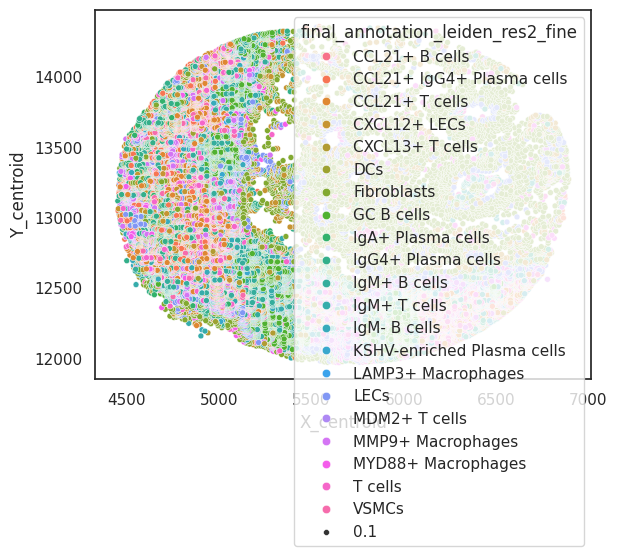

In [24]:
pdata = xen_dat.obs.loc[xen_dat.obs.core_id=='26',:]
sns.scatterplot(pdata, x='X_centroid', y='Y_centroid',
               size=0.1,
               hue='final_annotation_leiden_res2_fine')

In [27]:
# core 26 might be the limit

core_counts = xen_dat.obs.Core.value_counts()
keep = core_counts.loc[core_counts > 40000].index.tolist()
xen_dat_filter = xen_dat[xen_dat.obs.Core.isin(keep),:]
xen_dat_filter

View of AnnData object with n_obs × n_vars = 2405191 × 477
    obs: 'batch', 'Core', 'Size', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'leiden_res2', 'manual_celltype_annotation_leiden_broad', 'manual_celltype_annotation_leiden_broad_split_stromal', 'leiden_res5', 'final_annotation_leiden_res2_broad', 'final_annotation_leiden_res2_fine', 'X_centroid', 'Y_centroid', 'neigh_kmeans', 'neigh_kmeans_fine', 'ct_pred', 'core_id', 'spatial_lda_kmeans', 'motif'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'dendrog

ValueError: Shape of passed values is (13539, 1), indices imply (13539, 477)

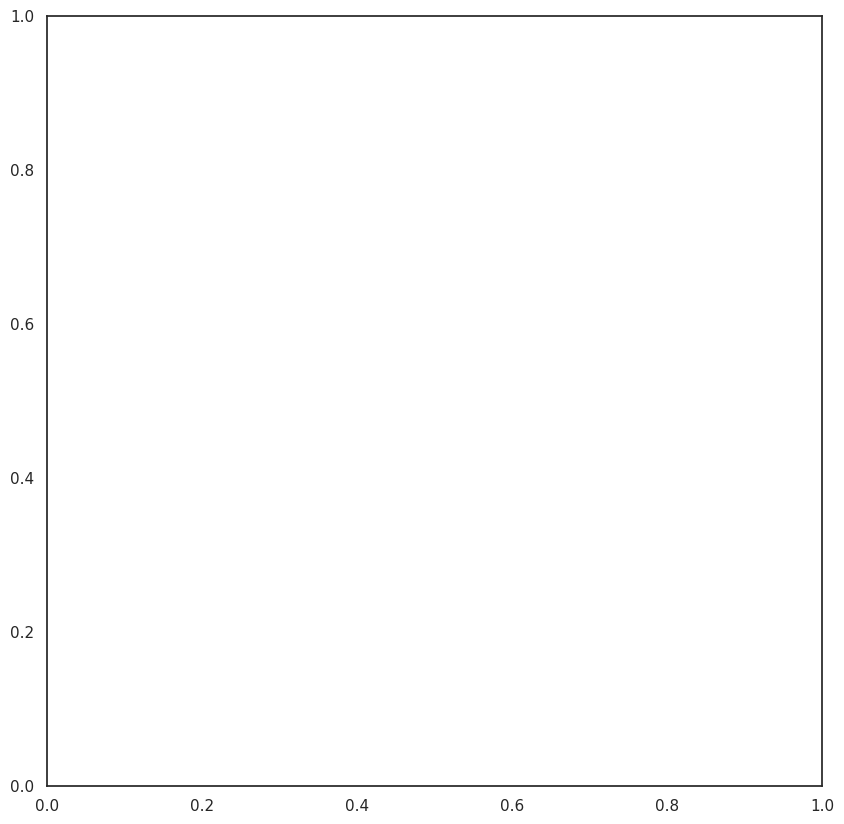

In [9]:
# fig, ax = plt.subplots(figsize=(10,10))
# sm.pl.spatial_scatterPlot(xen_dat, 
#               # x_lim = [8000,8500], y_lim=[4000,4500], 
#               colorBy='final_annotation_leiden_res2_fine', 
#               x_coordinate='X_centroid', y_coordinate='Y_centroid',
#               imageid='core_id', subset='29',
#                  plot_legend=True, 
#                  legend_size=6, **{'ax':ax})

In [39]:
# xenium centroids are in micron
xen_dat_filter = sm.tl.spatial_lda(xen_dat_filter, 
                                   x_coordinate='X_centroid', y_coordinate='Y_centroid', phenotype='ct_pred',
                          num_motifs=12,
                                   method='knn', 
                                   # radius=50, 
                          label='spatial_lda', imageid='Core')

Processing: [16]
Identifying the 10 nearest neighbours for every cell
Processing: [7]
Identifying the 10 nearest neighbours for every cell
Processing: [1]
Identifying the 10 nearest neighbours for every cell
Processing: [13]
Identifying the 10 nearest neighbours for every cell
Processing: [14]
Identifying the 10 nearest neighbours for every cell
Processing: [4]
Identifying the 10 nearest neighbours for every cell
Processing: [8]
Identifying the 10 nearest neighbours for every cell
Processing: [18]
Identifying the 10 nearest neighbours for every cell
Processing: [2]
Identifying the 10 nearest neighbours for every cell
Processing: [5]
Identifying the 10 nearest neighbours for every cell
Processing: [17]
Identifying the 10 nearest neighbours for every cell
Processing: [9]
Identifying the 10 nearest neighbours for every cell
Processing: [3]
Identifying the 10 nearest neighbours for every cell
Processing: [33]
Identifying the 10 nearest neighbours for every cell
Processing: [25]
Identifying

In [40]:
# # the old method
m = xen_dat_filter.uns['spatial_lda'].columns
motifs = xen_dat_filter.uns['spatial_lda'].apply(lambda x: m[np.argmax(x)], axis=1)
xen_dat_filter.obs['motif'] = motifs

In [41]:
xen_dat_filter = sm.tl.spatial_cluster(xen_dat_filter, df_name='spatial_lda', 
                                       method='kmeans', k=12, label='spatial_lda_kmeans')


Kmeans clustering


In [24]:
pdata = xen_dat_filter[xen_dat_filter.obs.core_id=='35',:]
pdata.obs.describe()

Core           Size  transcript_counts  control_probe_counts  \
count  107652.0  107652.000000      107652.000000         107652.000000   
mean       35.0      43.214718          60.865074              0.001904   
std         0.0      26.066370          29.492126              0.043809   
min        35.0       4.500000          10.000000              0.000000   
25%        35.0      30.170000          41.000000              0.000000   
50%        35.0      38.230000          56.000000              0.000000   
75%        35.0      49.400000          74.000000              0.000000   
max        35.0     918.480000         633.000000              2.000000   

       control_codeword_counts  unassigned_codeword_counts  \
count            107652.000000               107652.000000   
mean                  0.000994                    0.000037   
std                   0.031511                    0.006096   
min                   0.000000                    0.000000   
25%                   0.000000                    0.000000   
50%                   0.000000                    0.000000   
75%                   0.000000                    0.000000   
max                   1.000000                    1.000000   

       deprecated_codeword_counts   total_counts      cell_area  \
count                    107652.0  107652.000000  107652.000000   
mean                          0.0      60.865074      45.559164   
std                           0.0      29.492126      26.683743   
min                           0.0      10.000000       5.463906   
25%                           0.0      41.000000      32.196407   
50%                           0.0      56.000000      40.505158   
75%                           0.0      74.000000      51.974846   
max                           0.0     633.000000     979.393942   

        nucleus_area  n_genes_by_counts  log1p_n_genes_by_counts  \
count  107652.000000      107652.000000            107652.000000   
mean       23.381409          36.309024                 3.557292   
std         8.488865          12.923519                 0.361761   
min         3.747969           6.000000                 1.945910   
25%        18.965626          27.000000                 3.332205   
50%        23.436095          35.000000                 3.583519   
75%        26.913126          44.000000                 3.806662   
max       249.488290         143.000000                 4.969813   

       log1p_total_counts  pct_counts_in_top_10_genes  \
count       107652.000000               107652.000000   
mean             4.018952                   54.996941   
std              0.469845                    9.867532   
min              2.397895                   25.423729   
25%              3.737670                   48.437500   
50%              4.043051                   53.846154   
75%              4.317488                   60.000000   
max              6.452049                  100.000000   

       pct_counts_in_top_20_genes  pct_counts_in_top_50_genes  \
count               107652.000000               107652.000000   
mean                    75.930196                   99.020442   
std                     11.999511                    3.224842   
min                     41.860465                   70.078740   
25%                     67.213115                  100.000000   
50%                     73.770492                  100.000000   
75%                     82.857143                  100.000000   
max                    100.000000                  100.000000   

       pct_counts_in_top_150_genes       n_counts     X_centroid  \
count                     107652.0  107652.000000  107652.000000   
mean                         100.0      60.865074    8011.543027   
std                            0.0      29.492126     618.930716   
min                          100.0      10.000000    6690.547363   
25%                          100.0      41.000000    7516.266968   
50%                          100.0      56.000000  

## Testing on a subset of the data

In [175]:
test_dat = xen_dat_filter[xen_dat_filter.obs.core_id=='35',:].copy()

In [9]:
test_dat = sm.tl.spatial_lda(test_dat, 
                                   x_coordinate='X_centroid', y_coordinate='Y_centroid', phenotype='ct_pred',
                          num_motifs=12,
                                   method='knn', 
                                   # radius=50, 
                          label='spatial_lda', imageid='Core')
test_dat = sm.tl.spatial_cluster(test_dat, df_name='spatial_lda', 
                                       method='kmeans', k=12, label='spatial_lda_kmeans')


Processing: [35]
Identifying the 10 nearest neighbours for every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.2790201085956541
Gathering the latent weights
Kmeans clustering


<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

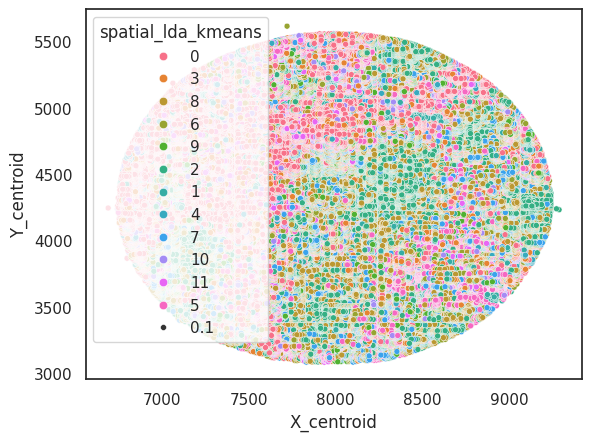

In [11]:
sns.scatterplot(test_dat.obs, x='X_centroid', y='Y_centroid',
               size=0.1,
               hue='spatial_lda_kmeans')

## Using the LDA defined from CODEX

Need to convert 'ct_pred' to CODEX labels

In [4]:
from sklearn.neighbors import BallTree
import re
import gensim
from gensim.test.utils import datapath
import gensim.corpora as corpora
from scipy.stats import dirichlet
from scipy.stats import multinomial
from scipy.stats import dirichlet_multinomial

In [3]:
codex = ad.read_h5ad("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/CD_analysis/aSMA_CD21_analysis/all_regions_dat.h5ad")
codex

AnnData object with n_obs × n_vars = 3895114 × 38
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'new_pheno', 'region'
    uns: 'lda_10', 'lda_10_probability', 'lda_12', 'lda_12_probability', 'lda_15', 'lda_15_probability', 'lda_8', 'lda_8_probability', 'spatial_lda', 'spatial_lda_probability'

In [14]:
codex.uns['lda_12_probability']

Motif_0  Motif_1  Motif_2  Motif_3  Motif_4  Motif_5  \
B_Cell              0.358    0.050    0.835    0.109    0.402    0.078   
CD4_T_Cell          0.151    0.608    0.066    0.213    0.017    0.260   
CD8_T_Cell          0.031    0.127    0.025    0.113    0.014    0.426   
Cytotoxic_T_Cell    0.007    0.000    0.000    0.000    0.000    0.000   
Endothelial         0.240    0.064    0.006    0.029    0.046    0.008   
Lymphatics          0.000    0.011    0.000    0.029    0.000    0.000   
Macrophage          0.065    0.093    0.020    0.393    0.034    0.054   
Mast_Cell           0.000    0.000    0.000    0.000    0.000    0.000   
Neutrophil          0.000    0.000    0.000    0.000    0.000    0.000   
Plasma_Cell         0.007    0.000    0.000    0.021    0.000    0.000   
Stromal             0.043    0.007    0.015    0.000    0.432    0.012   
T_cell              0.005    0.000    0.000    0.000    0.003    0.000   
Tfh                 0.000    0.000    0.021    0.000    0.044    0.004   
Treg                0.000    0.000    0.003    0.000    0.000    0.000   
cDC1                0.000    0.005    0.004    0.012    0.000    0.043   
cDC2                0.000    0.000    0.000    0.000    0.000    0.111   
immune              0.000    0.000    0.000    0.000    0.000    0.000   
myeloid             0.000    0.005    0.002    0.011    0.002    0.000   
pDC                 0.082    0.013    0.000    0.031    0.005    0.002   

                  Motif_6  Motif_7  Motif_8  Motif_9  Motif_10  Motif_11  
B_Cell              0.178    0.036    0.056    0.232     0.041     0.186  
CD4_T_Cell          0.348    0.039    0.199    0.351     0.093     0.089  
CD8_T_Cell          0.153    0.031    0.131    0.000     0.050     0.038  
Cytotoxic_T_Cell    0.000    0.000    0.000    0.000     0.000     0.017  
Endothelial         0.023    0.458    0.374    0.265     0.054     0.036  
Lymphatics          0.000    0.007    0.000    0.000     0.006     0.000  
Macrophage          0.083    0.325    0.118    0.135     0.124     0.041  
Mast_Cell           0.000    0.000    0.000    0.000     0.000     0.000  
Neutrophil          0.000    0.000    0.020    0.000     0.000     0.000  
Plasma_Cell         0.006    0.066    0.038    0.002     0.599     0.000  
Stromal             0.007    0.000    0.012    0.016     0.014     0.568  
T_cell              0.000    0.010    0.010    0.000     0.010     0.002  
Tfh                 0.000    0.000    0.000    0.000     0.000     0.000  
Treg                0.000    0.000    0.000    0.000     0.000     0.000  
cDC1                0.008    0.000    0.000    0.000     0.000     0.014  
cDC2                0.000    0.000    0.000    0.000     0.000     0.000  
immune              0.010    0.000    0.000    0.000     0.000     0.000  
myeloid             0.000    0.015    0.000    0.000     0.004     0.000  
pDC                 0.169    0.007    0.010    0.000     0.000     0.005

In [31]:
xen_dat_filter.obs.ct_pred.unique().tolist() - conv_ct.keys()

{'Endothelial cells'}

In [32]:
conv_ct = {
    'Naive CD4 and Naive CD8 T cells':'CD4_T_Cell',
 'Memory or effector T cells':'CD4_T_Cell',
 'Cytotoxic CD8 T cells':'CD8_T_Cell',
 'Naive B cells':'B_Cell',
 'Monocytes':'Macrophage',
 'Fibroblastic stromal cell, type 1':'Stromal',
 'blood endothelial cell':'Endothelial',
    'Endothelial cells':'Endothelial',
 'lymphatic endothelial cell':'Lymphatics',
 'Macrophages':'Macrophage',
 'Fibroblastic stromal cell, type 2':'Stromal',
 'NK cells':'immune',
 'Plasma cells':'Plasma_Cell',
 'Plasmacytoid dendritic cells':'pDC',
 'Activated and memory B cells':'B_Cell',
 'T Follicular Helper cells':'Tfh',
 'Classic Dendritic cells':'cDC1',
 'Fibroblasts':'Stromal',
 'Stromal cells':'Stromal',
 'ACTA2+ perivascular reticular cells':'Stromal',
 'Activated and migratory cDC':'cDC2',
 'Germinal center B cells':'B_Cell',
 'Regulatory T cells':'Treg',
 'Granulocytes':'Neutrophil',
 'FDC':'Stromal',
 'Follicular dendritic cells':'Stromal'
          }

In [6]:
test_dat.obs['ct_codex'] = [conv_ct[ct] for ct in test_dat.obs['ct_pred'].astype('str').values]

### Trying to manually rebuild

In [33]:
# not all converted cell types in LDA probs
lda_probs = codex.uns['lda_12_probability'].copy()
lda_probs = lda_probs.loc[test_dat.obs['ct_codex'].unique(),:]



Motif_0  Motif_1  Motif_2  Motif_3  Motif_4  Motif_5  Motif_6  \
CD4_T_Cell     0.151    0.608    0.066    0.213    0.017    0.260    0.348   
CD8_T_Cell     0.031    0.127    0.025    0.113    0.014    0.426    0.153   
B_Cell         0.358    0.050    0.835    0.109    0.402    0.078    0.178   
Macrophage     0.065    0.093    0.020    0.393    0.034    0.054    0.083   
Stromal        0.043    0.007    0.015    0.000    0.432    0.012    0.007   
Endothelial    0.240    0.064    0.006    0.029    0.046    0.008    0.023   
Lymphatics     0.000    0.011    0.000    0.029    0.000    0.000    0.000   
immune         0.000    0.000    0.000    0.000    0.000    0.000    0.010   
Plasma_Cell    0.007    0.000    0.000    0.021    0.000    0.000    0.006   
pDC            0.082    0.013    0.000    0.031    0.005    0.002    0.169   
Tfh            0.000    0.000    0.021    0.000    0.044    0.004    0.000   
cDC1           0.000    0.005    0.004    0.012    0.000    0.043    0.008   
cDC2           0.000    0.000    0.000    0.000    0.000    0.111    0.000   
Treg           0.000    0.000    0.003    0.000    0.000    0.000    0.000   
Neutrophil     0.000    0.000    0.000    0.000    0.000    0.000    0.000   

             Motif_7  Motif_8  Motif_9  Motif_10  Motif_11  
CD4_T_Cell     0.039    0.199    0.351     0.093     0.089  
CD8_T_Cell     0.031    0.131    0.000     0.050     0.038  
B_Cell         0.036    0.056    0.232     0.041     0.186  
Macrophage     0.325    0.118    0.135     0.124     0.041  
Stromal        0.000    0.012    0.016     0.014     0.568  
Endothelial    0.458    0.374    0.265     0.054     0.036  
Lymphatics     0.007    0.000    0.000     0.006     0.000  
immune         0.000    0.000    0.000     0.000     0.000  
Plasma_Cell    0.066    0.038    0.002     0.599     0.000  
pDC            0.007    0.010    0.000     0.000     0.005  
Tfh            0.000    0.000    0.000     0.000     0.000  
cDC1           0.000    0.000    0.000     0.000     0.014  
cDC2           0.000    0.000    0.000     0.000     0.000  
Treg           0.000    0.000    0.000     0.000     0.000  
Neutrophil     0.000    0.020    0.000     0.000     0.000

In [177]:
lda_alpha = lda_probs.to_numpy() / lda_probs.sum(axis=1).to_numpy()[:,None]
lda_alpha = pd.DataFrame(lda_alpha, index=lda_probs.index.values)

In [213]:
# lda_motif1 = lda_probs.Motif_4
lda_motif1 = lda_alpha.iloc[:,9]
lda_motif1 = lda_motif1.loc[lda_motif1!= 0]
# lda_motif1 = lda_motif1/lda_motif1.sum()

# ct_freq = test_probs.loc[lda_motif1.index, 2]+0.1
# ct_freq = ct_freq / ct_freq.sum()
# ct_freq = ct_freq.to_list()

# dirichlet.pdf(ct_freq, lda_motif1.to_list())

ct_freq = test_probs.loc[lda_motif1.index, 1]

dirichlet_multinomial.pmf(x=ct_freq.to_list(), alpha=lda_motif1, n=ct_freq.sum())

1.2549651086401119e-08

In [159]:
# dirichlet.pdf(lda_motif1.to_list(), (test_probs.loc[lda_motif1.index, 0]+0.1).to_list())
dirichlet.pdf(ct_freq, lda_motif1.to_list())
# rv = multinomial(15, lda_probs.Motif_6.to_numpy()[:,None])
# rv.pmf(test_probs.to_numpy()[:,0])
# multinomial.pmf(test_probs.to_numpy()[:,0], n=15, p=lda_probs.Motif_1.to_list())

0.1289121401893341

In [190]:
test_probs

0     1     2     3     4     5     6     7     8     9
CD4_T_Cell   36.0  21.0  23.0  18.0  13.0  18.0  19.0  23.0  20.0  15.0
CD8_T_Cell    2.0   6.0   5.0   6.0   5.0   5.0   7.0   5.0   5.0   6.0
B_Cell       17.0  33.0  38.0  30.0  27.0  33.0  30.0  42.0  38.0  29.0
Macrophage    6.0   4.0   3.0   4.0   3.0   3.0   3.0   2.0   2.0   4.0
Stromal       0.0   1.0   2.0   1.0   2.0   1.0   1.0   2.0   2.0   2.0
Endothelial   2.0   4.0   0.0   6.0   8.0   4.0   6.0   0.0   3.0   7.0
Lymphatics    1.0   0.0   0.0   2.0   3.0   2.0   2.0   1.0   1.0   2.0
immune        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Plasma_Cell   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
pDC           1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Tfh           1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
cDC1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
cDC2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Treg          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Neutrophil    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [100]:
test_probs.to_numpy()[:,0]

array([36.,  2., 17.,  6.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.])

In [94]:
unq, unq_counts = np.unique(ind[0], return_counts=True)
unq_counts

array([17, 36,  2,  2,  1,  6,  1,  1])

In [51]:
# getting the neighbors
data = pd.DataFrame({'x':test_dat.obs['X_centroid'], 'y':test_dat.obs['Y_centroid'],'phenotype':test_dat.obs['ct_codex']})
radius = 30
kdt = BallTree(data[['x','y']], metric='euclidean') 
ind = kdt.query_radius(data[['x','y']], r=radius, return_distance=False)

In [52]:
phenomap = dict(zip(list(range(len(ind))), data['phenotype'])) # Used for mapping
for i in range(len(ind)):
    ind[i] = [phenomap[letter] for letter in ind[i]]

In [95]:
# get probs
def ct_prob(ar):
    unq, unq_counts = np.unique(ar, return_counts=True)
    unq_counts = unq_counts/len(ar)
    return pd.Series(dict(zip(unq, unq_counts)))
def ct_count(ar):
    unq, unq_counts = np.unique(ar, return_counts=True)
    # unq_counts = unq_counts/len(ar)
    return pd.Series(dict(zip(unq, unq_counts)))

In [96]:
# freqs
# ind_probs = list(map(ct_prob, ind))
# ind_prob_df = pd.concat(ind_probs, axis=1)
# ind_prob_df.fillna(0, inplace=True)

# counts
ind_cnt = list(map(ct_count, ind))
ind_cnt_df = pd.concat(ind_cnt, axis=1)
ind_cnt_df.fillna(0, inplace=True)

In [136]:
# test_probs = ind_prob_df.iloc[:,0:10]
test_probs = ind_cnt_df.iloc[:,0:10]
test_probs = test_probs.loc[lda_probs.index.values,:]
test_probs

0     1     2     3     4     5     6     7     8     9
CD4_T_Cell   36.0  21.0  23.0  18.0  13.0  18.0  19.0  23.0  20.0  15.0
CD8_T_Cell    2.0   6.0   5.0   6.0   5.0   5.0   7.0   5.0   5.0   6.0
B_Cell       17.0  33.0  38.0  30.0  27.0  33.0  30.0  42.0  38.0  29.0
Macrophage    6.0   4.0   3.0   4.0   3.0   3.0   3.0   2.0   2.0   4.0
Stromal       0.0   1.0   2.0   1.0   2.0   1.0   1.0   2.0   2.0   2.0
Endothelial   2.0   4.0   0.0   6.0   8.0   4.0   6.0   0.0   3.0   7.0
Lymphatics    1.0   0.0   0.0   2.0   3.0   2.0   2.0   1.0   1.0   2.0
immune        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Plasma_Cell   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
pDC           1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Tfh           1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
cDC1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
cDC2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Treg          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
Neutrophil    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [67]:
test_norm = (test_probs**2).sum()
lda_norm = (lda_probs**2).sum()
mat_norm = np.sqrt(np.add.outer(test_norm.to_numpy(), lda_norm.to_numpy()))
mat_norm.shape

(10, 12)

In [68]:
lda_prod = 2*np.dot(test_probs.T.to_numpy(), lda_probs.to_numpy())
lda_prod.shape

(10, 12)

In [74]:
lda_pred = mat_norm - lda_prod
np.apply_along_axis(np.argmin, 1, lda_pred)

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [75]:
test_dat.obs.spatial_lda_kmeans.head(10)

afankfad-1-1    0
afanlgeg-1-1    3
afanlgik-1-1    0
afanlhke-1-1    8
afanmakj-1-1    8
afanookm-1-1    8
afanpfhd-1-1    6
afanpklc-1-1    0
afanpmjc-1-1    3
afaobijb-1-1    6
Name: spatial_lda_kmeans, dtype: object

### Re-did codex LDA, saved the model

In [5]:
temp_file = datapath("codex_LDA_12topic")
lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)

In [33]:
xen_dat_filter.obs['ct_codex'] = [conv_ct[ct] for ct in xen_dat_filter.obs['ct_pred'].astype('str').values]

In [7]:
adata_list = [xen_dat_filter[xen_dat_filter.obs['core_id'] == i] for i in xen_dat_filter.obs['core_id'].unique()]

In [21]:
r_spatial_lda_internal = lambda x: spatial_lda_internal(adata_subset=x,
                                                            x_coordinate='X_centroid',
                                                            y_coordinate='Y_centroid',
                                                        z_coordinate=None,
                                                            phenotype='ct_codex', 
                                                            method='radius', 
                                                            radius=50, 
                                                            knn=None, 
                                                            imageid='core_id') 

In [22]:
all_data = list(map(r_spatial_lda_internal, adata_list))

Processing: ['16']
Identifying neighbours within 50 pixels of every cell
Processing: ['7']
Identifying neighbours within 50 pixels of every cell
Processing: ['1']
Identifying neighbours within 50 pixels of every cell
Processing: ['13']
Identifying neighbours within 50 pixels of every cell
Processing: ['14']
Identifying neighbours within 50 pixels of every cell
Processing: ['4']
Identifying neighbours within 50 pixels of every cell
Processing: ['8']
Identifying neighbours within 50 pixels of every cell
Processing: ['18']
Identifying neighbours within 50 pixels of every cell
Processing: ['2']
Identifying neighbours within 50 pixels of every cell
Processing: ['5']
Identifying neighbours within 50 pixels of every cell
Processing: ['17']
Identifying neighbours within 50 pixels of every cell
Processing: ['9']
Identifying neighbours within 50 pixels of every cell
Processing: ['3']
Identifying neighbours within 50 pixels of every cell
Processing: ['33']
Identifying neighbours within 50 pixels 

In [23]:
texts = np.concatenate( all_data, axis=0 ).tolist()
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [24]:
topic_weights = []
for row_list in lda_model[corpus]:
    tmp = np.zeros(12)
    for i, w in row_list:
        tmp[i] = w
    topic_weights.append(tmp)
# conver to dataframe
arr = pd.DataFrame(topic_weights, index=xen_dat_filter.obs.index).fillna(0)
arr = arr.add_prefix('Motif_')
xen_dat_filter.uns['codex_LDApred'] = arr

In [25]:
xen_dat_filter = sm.tl.spatial_cluster(xen_dat_filter, df_name='codex_LDApred', 
                                       method='kmeans', k=12, label='spatial_lda_kmeans')

Kmeans clustering


In [26]:
# isolate the weights of phenotypes
pattern = "(\d\.\d+).\"(.*?)\""
cell_weight = pd.DataFrame(index=np.unique(xen_dat_filter.obs['ct_codex']))
for i in range(0, len(lda_model.print_topics())):
    level1 = lda_model.print_topics()[i][1]
    tmp = pd.DataFrame(re.findall(pattern, level1))
    tmp.index = tmp[1]
    tmp = tmp.drop(columns=1)
    tmp.columns = ['Motif_'+ str(i)]
    cell_weight = cell_weight.merge(tmp, how='outer', left_index=True, right_index=True)
# fill zeros
cell_weight = cell_weight.fillna(0).astype(float)
xen_dat_filter.uns['codex_LDApred_probability'] = cell_weight

<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

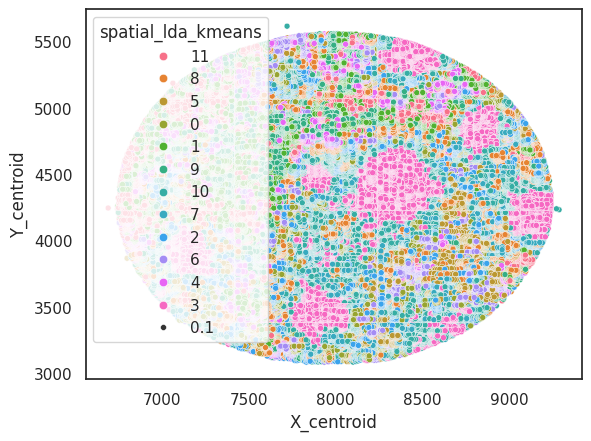

In [25]:
sns.scatterplot(test_dat.obs, x='X_centroid', y='Y_centroid',
               size=0.1,
               hue='spatial_lda_kmeans')

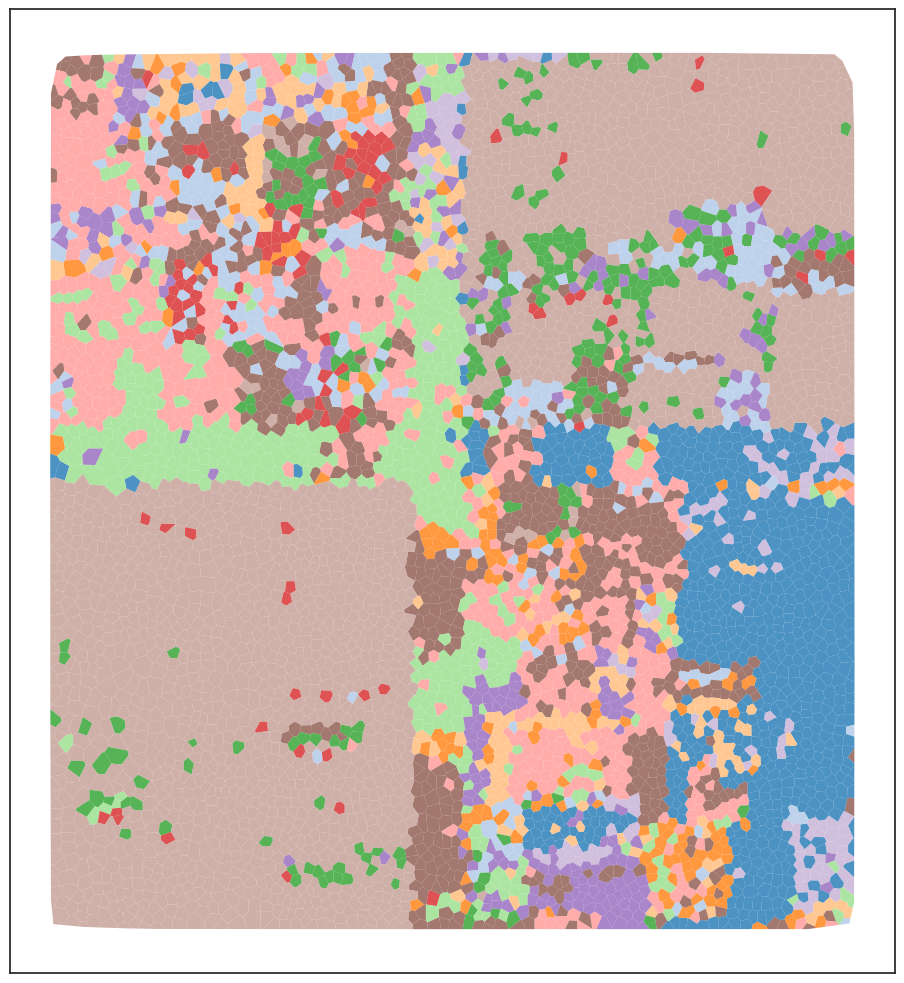

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(xen_dat_filter, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='spatial_lda_kmeans', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

# visualize

In [48]:
xen_dat_filter.obs.core_id.value_counts()

core_id
8     148594
7     136328
23    128818
17    123581
16    119079
33    115325
27    108735
35    107652
37    107365
14    104667
36    102897
13     98317
9      97044
4      96331
5      96296
25     95441
34     91713
38     90965
19     83926
1      82298
2      80267
18     71636
3      71028
26     46888
Name: count, dtype: int64

<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

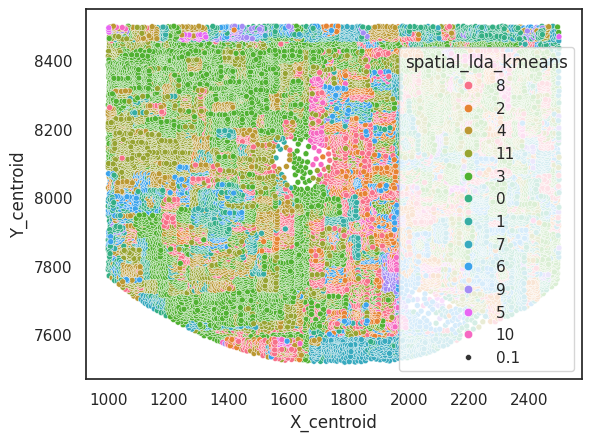

In [27]:
pdata = xen_dat_filter.obs.loc[xen_dat_filter.obs.core_id=='13',:]
pdata = pdata.loc[(pdata['X_centroid'] > 1000) & (pdata['X_centroid'] < 2500) & (pdata['Y_centroid'] > 7000) & (pdata['Y_centroid'] < 8500)]
sns.scatterplot(pdata, x='X_centroid', y='Y_centroid',
               size=0.1,
               hue='spatial_lda_kmeans')

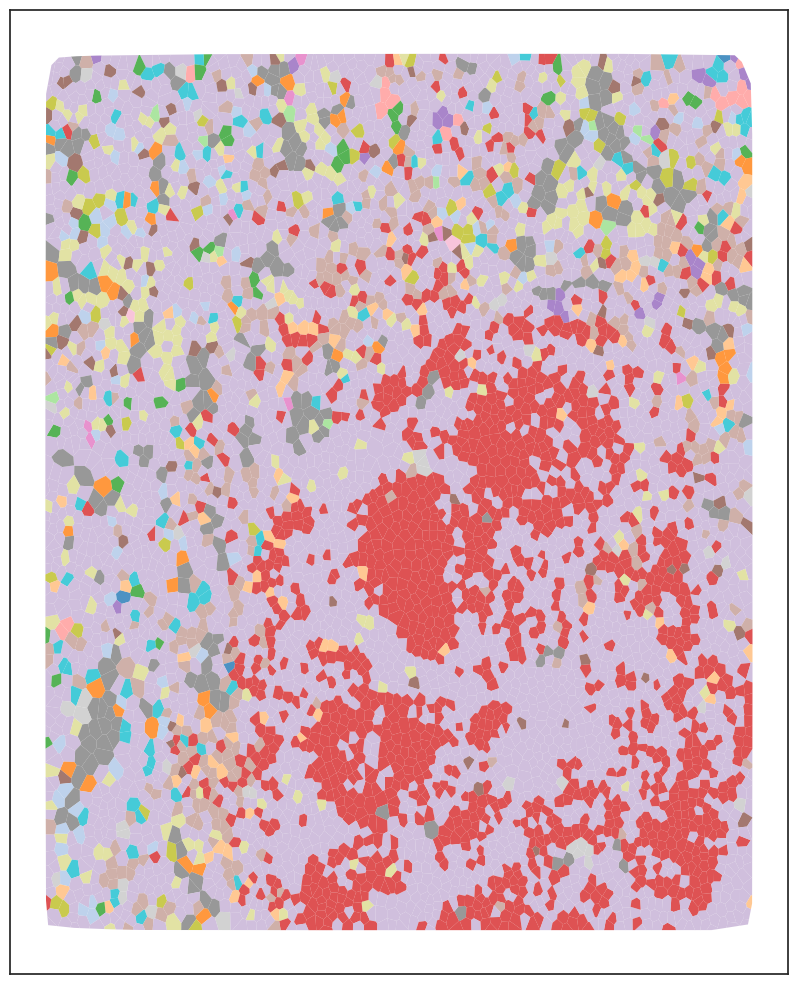

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(xen_dat_filter, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='final_annotation_leiden_res2_fine', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

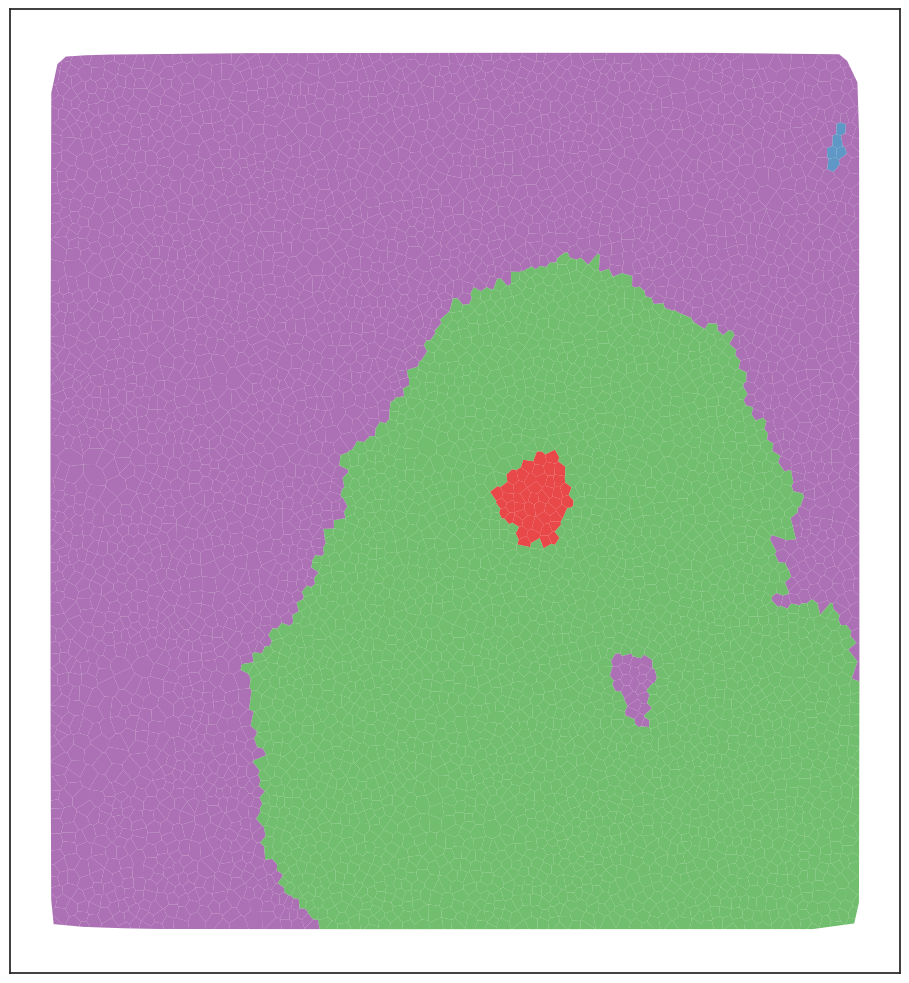

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(xen_dat_filter, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='neigh_kmeans_fine', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

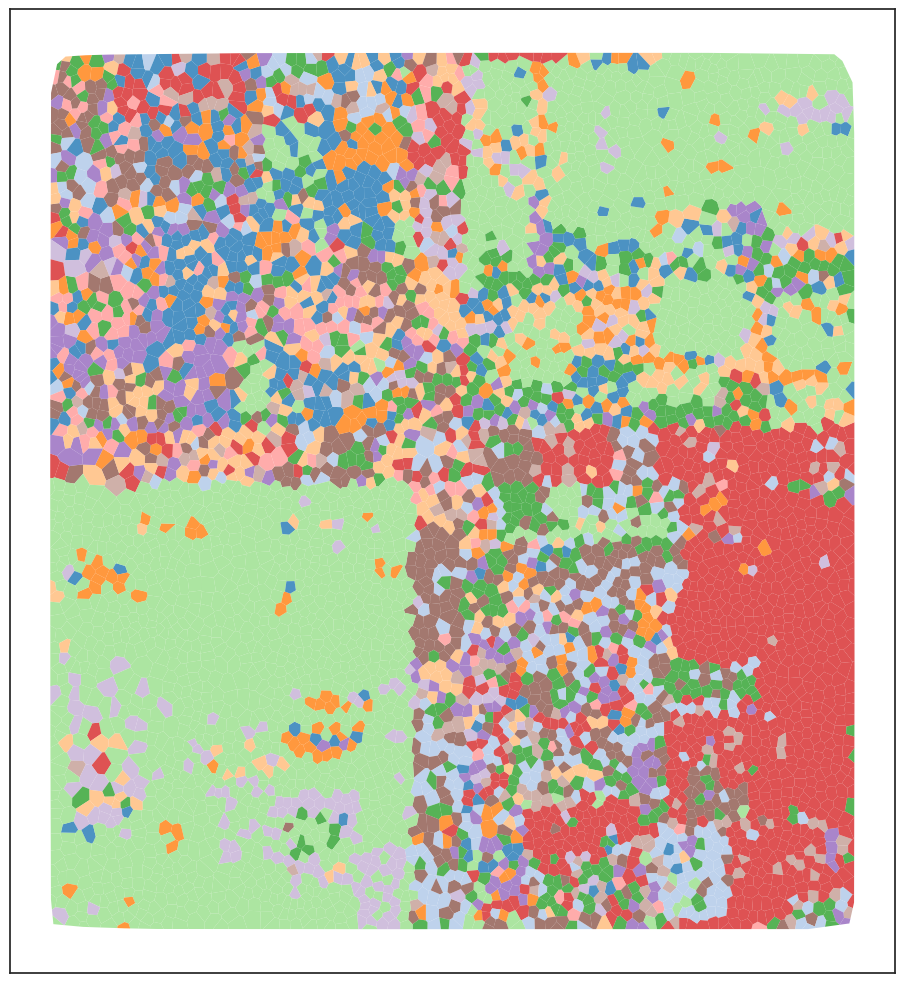

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(xen_dat_filter, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='spatial_lda_kmeans', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

# Examine cell interactions

PRC -> Macrophage
    CCN1 / TLR2
    ADAM12 / ITGA9
    THBS1 / LRP1
    VEGFC / ITGA9

TRC -> BEC, Macrophage, Plasma cells

In [5]:
goi = ['CCN1','TLR2','ADAM12','ITGA9','THBS1','LRP1','VEGFC']
set(goi).intersection(xen_dat_filter.var_names)

{'THBS1'}

In [ ]:
goi = ['THBS1','VEGFA', 'FGF2','DLL4','ITGB3','MET','NRP1','SDC1']

In [9]:
xen_dat_filter.var_names.to_list()

['ABCC11',
 'ACE2',
 'ACKR1',
 'ACTA2',
 'ACTG2',
 'ADAM28',
 'ADAMTS1',
 'ADGRE1',
 'ADGRL4',
 'ADH1C',
 'ADH4',
 'ADIPOQ',
 'AGER',
 'AGR3',
 'AHSP',
 'AIF1',
 'AKT1',
 'ALAS2',
 'ALDH1A3',
 'AMY2A',
 'ANGPT1',
 'ANGPT2',
 'ANPEP',
 'APCDD1',
 'APOA5',
 'APOBEC3A',
 'APOLD1',
 'AQP2',
 'AQP3',
 'AQP8',
 'AQP9',
 'AR',
 'ARFGEF3',
 'ASCL1',
 'ASCL3',
 'ASPN',
 'BAMBI',
 'BANK1',
 'BASP1',
 'BBOX1',
 'BCL2L11',
 'BMX',
 'BTNL9',
 'C15orf48',
 'C1orf162',
 'C1orf194',
 'C20orf85',
 'C4A',
 'C5orf46',
 'C6orf118',
 'C7',
 'CA4',
 'CAPN8',
 'CAV1',
 'CAVIN1',
 'CAVIN2',
 'CCDC39',
 'CCDC78',
 'CCL19',
 'CCL21',
 'CCL27',
 'CCL5',
 'CCNB2',
 'CCR2',
 'CCR5',
 'CCR7',
 'CD14',
 'CD163',
 'CD19',
 'CD1A',
 'CD1C',
 'CD1D',
 'CD1E',
 'CD2',
 'CD24',
 'CD247',
 'CD27',
 'CD274',
 'CD28',
 'CD300E',
 'CD34',
 'CD38',
 'CD3D',
 'CD3E',
 'CD4',
 'CD40',
 'CD40LG',
 'CD5',
 'CD5L',
 'CD68',
 'CD69',
 'CD70',
 'CD79A',
 'CD83',
 'CD86',
 'CD8A',
 'CD93',
 'CDH16',
 'CDK1',
 'CENPF',
 'CFAP53',
 'CF

In [3]:
# xen_dat_filter.obs.loc[xen_dat_filter.obs.ct_pred=="ACTA2+ perivascular reticular cells" ,"core_id"].value_counts()
xen_dat_filter.obs.core_id.value_counts()

core_id
8     148594
7     136328
23    128818
17    123581
16    119079
33    115325
27    108735
35    107652
37    107365
14    104667
36    102897
13     98317
9      97044
4      96331
5      96296
25     95441
34     91713
38     90965
19     83926
1      82298
2      80267
18     71636
3      71028
26     46888
Name: count, dtype: int64

In [4]:
test_dat = xen_dat_filter[xen_dat_filter.obs.core_id=='35',:].copy()
test_dat.obs.ct_pred.value_counts()

ct_pred
Naive B cells                          50630
Memory or effector T cells             21037
Naive CD4 and Naive CD8 T cells         6019
Fibroblastic stromal cell, type 2       4563
Cytotoxic CD8 T cells                   4133
Activated and memory B cells            3723
Monocytes                               3655
Plasma cells                            3345
blood endothelial cell                  2858
Plasmacytoid dendritic cells            2218
Macrophages                             1410
NK cells                                1157
Fibroblastic stromal cell, type 1       1030
lymphatic endothelial cell               656
T Follicular Helper cells                436
Classic Dendritic cells                  243
Germinal center B cells                  143
ACTA2+ perivascular reticular cells      127
Stromal cells                             71
Activated and migratory cDC               67
Regulatory T cells                        51
FDC                                       32
Fi

<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

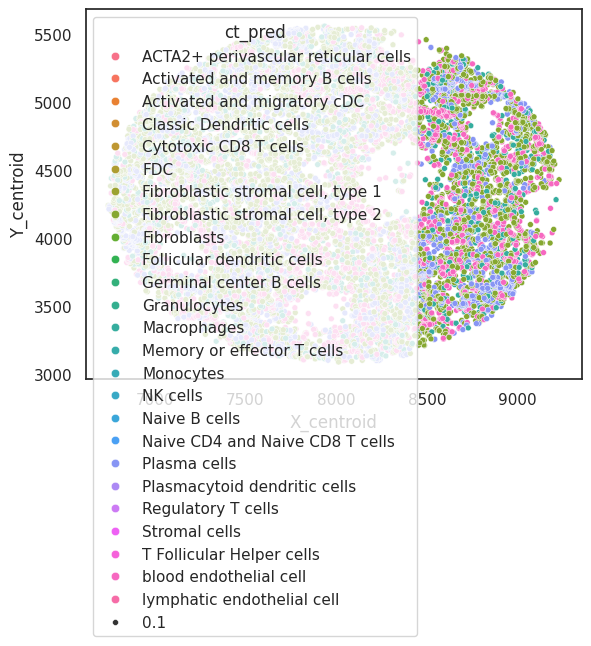

In [11]:
pdata = test_dat.obs.copy()
pdata = pdata.loc[pdata.ct_pred.isin(['Fibroblastic stromal cell, type 2', 'Macrophages','blood endothelial cell','Plasma cells']),:]
pdata = pdata.loc[(pdata['X_centroid'] > 1500) & (pdata['X_centroid'] < 2500) & (pdata['Y_centroid'] > 8000) & (pdata['Y_centroid'] < 9000)]
sns.scatterplot(pdata, x='X_centroid', y='Y_centroid',
               size=0.1,
               hue='ct_pred')

## look at expression by cell distance

...and motif

In [5]:
import scipy as sci
import scanpy as sc
import statsmodels.api as sm

In [6]:
def lowess_with_confidence_bounds(
    x, y, eval_x, N=200, conf_interval=0.9, lowess_kw=None
):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


### Testing

In [ ]:
test_dat = xen_dat_filter[xen_dat_filter.obs.core_id=='35',:].copy()

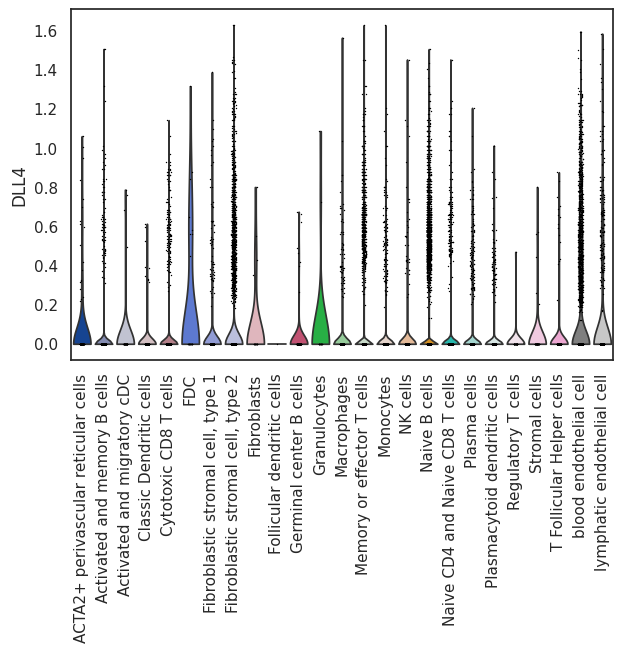

In [179]:
# sc.pl.violin(xen_dat_filter, keys="TGFB1", groupby="ct_pred", rotation=90, size=0)
sc.pl.violin(test_dat, keys="DLL4", groupby="ct_pred", rotation=90)
# sc.pl.violin(test_dat, keys="NOTCH1", groupby="ct_pred", rotation=90)

In [21]:
# c = 'Macrophages'
c='Memory or effector T cells'
# c = 'blood endothelial cell'
# c = 'Naive CD4 and Naive CD8 T cells'
# cc = 'ACTA2+ perivascular reticular cells'
cc = 'Fibroblastic stromal cell, type 2'
# cc = 'FDC'

ref_dat = test_dat.obs.loc[test_dat.obs['ct_pred']==c, ['X_centroid', 'Y_centroid']]
# ref_dat = test_dat.obs.loc[test_dat.obs['ct_codex']==c, ['X_centroid', 'Y_centroid']]
q_dat = test_dat.obs.loc[test_dat.obs['ct_pred']==cc, ['X_centroid', 'Y_centroid']]
# q_dat = test_dat.obs.loc[test_dat.obs['ct_codex']==cc, ['X_centroid', 'Y_centroid']]
ref_tree = sci.spatial.cKDTree(ref_dat)
dist_res = ref_tree.query(q_dat, k=1)

In [43]:
# test_dat.obs.loc[test_dat.obs['ct_pred']==cc , "spatial_lda_kmeans"].value_counts()
test_dat.obs.loc[test_dat.obs['ct_codex']==cc , "spatial_lda_kmeans"].value_counts()

spatial_lda_kmeans
9     1410
8      997
5      758
0      755
3      304
1      275
11     274
10     272
2      268
7      257
6      166
4      113
Name: count, dtype: int64

In [113]:
# dist_res
len(dist_res[1])
# dist_res[1].max()
# test_dat.obs.loc[test_dat.obs['ct_pred']==cc, :].iloc[268,:]

1410

In [11]:
pdata = test_dat.obs.loc[test_dat.obs['ct_pred']==cc,:].copy()
pdata.spatial_lda_kmeans.unique()

['0', '11', '7', '3', '4', ..., '10', '6', '2', '1', '9']
Length: 12
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [19]:
gene = 'DLL4'

/tmp/ipykernel_1560245/1328364290.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_1560245/1328364290.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:

invalid value encountered in divide



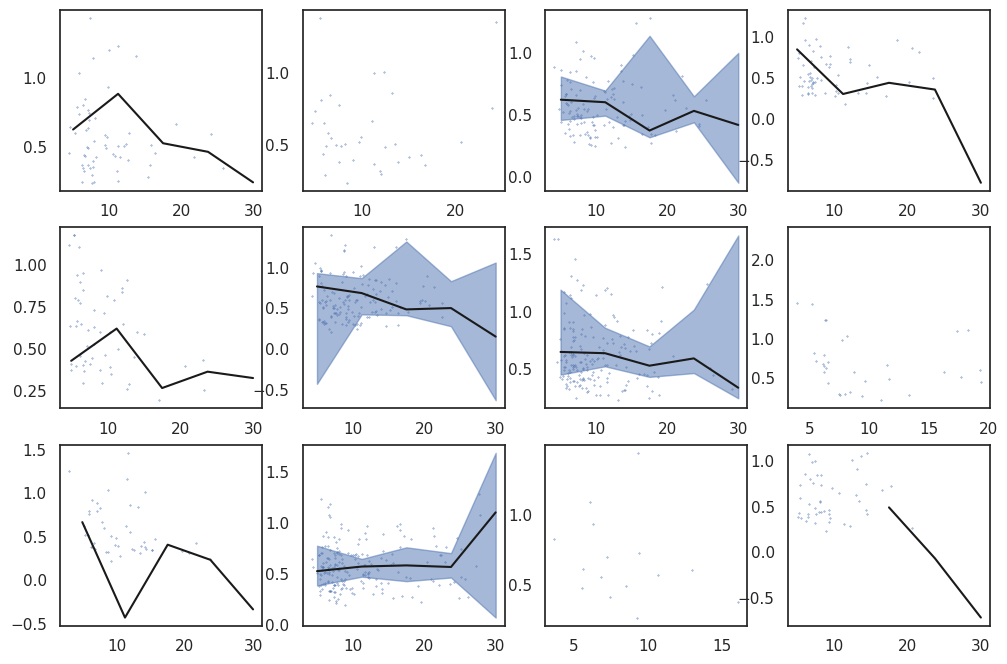

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12,8), sharey=False)
axs = axs.ravel()

eval_x = np.linspace(5, 30, 5)
pdata = test_dat.obs.loc[test_dat.obs['ct_pred']==cc,:].copy()
# pdata = test_dat.obs.loc[test_dat.obs['ct_codex']==cc,:].copy()
pdata['dist'] = dist_res[0]
pdata['gene'] = xen_dat_filter[pdata.index.values, gene].X.toarray().flatten()
pdata = pdata.loc[pdata.gene > 0,:]
pdata = pdata.loc[pdata.dist < 30,:]
for i in range(len(pdata.spatial_lda_kmeans.unique())):
    motif_i = pdata.spatial_lda_kmeans.unique()[i]
    pdata_ = pdata.loc[pdata.spatial_lda_kmeans==motif_i,:]
    smoothed, bottom, top = lowess_with_confidence_bounds(
        pdata_['dist'], pdata_['gene'], eval_x, lowess_kw={"frac": 0.1}
    )

    # Plot the confidence interval and fit
    axs[i].scatter(pdata_['dist'], pdata_['gene'], s=0.1)
    axs[i].plot(eval_x, smoothed, c="k")
    axs[i].fill_between(eval_x, bottom, top, alpha=0.5, color="b")

/tmp/ipykernel_1593003/1328364290.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_1593003/1328364290.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



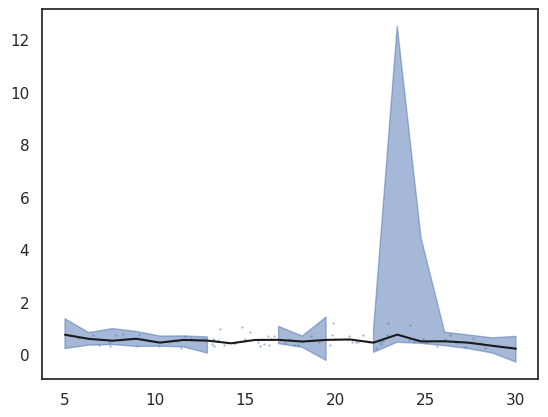

In [95]:
eval_x = np.linspace(5, 30, 20)
# gene = 'TNC'
pdata = q_dat.copy()
pdata['dist'] = dist_res[0]
pdata['gene'] = xen_dat_filter[pdata.index.values, gene].X.toarray().flatten()
# pdata['gene'] = xen_dat_filter[pdata.index.values, gene].layers['counts'].toarray().flatten()
pdata = pdata.loc[pdata.gene > 0,:]
pdata = pdata.loc[pdata.dist < 30,:]

smoothed, bottom, top = lowess_with_confidence_bounds(
    pdata['dist'], pdata['gene'], eval_x, lowess_kw={"frac": 0.1}
)

# Plot the confidence interval and fit
fig, ax = plt.subplots()
ax.scatter(pdata['dist'], pdata['gene'], s=0.1)
ax.plot(eval_x, smoothed, c="k")
ax.fill_between(eval_x, bottom, top, alpha=0.5, color="b")



In [71]:
# what if we plot relative binned expression

# eval_x = np.linspace(5, 50, 10)
# gene = 'TNC'
pdata = q_dat.copy()
pdata['dist'] = dist_res[0]
pdata['gene'] = xen_dat_filter[pdata.index.values, gene].X.toarray().flatten()
pdata = pdata.loc[pdata.dist < 30,:]
pdata['dist_bin'] = pd.cut(pdata['dist'], 15)
pdata_agg = pdata.groupby('dist_bin').gene.apply(lambda x: np.sum(x>0)/len(x))

pdata_agg


/tmp/ipykernel_1593003/464098534.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



dist_bin
(3.25, 5.056]       0.455882
(5.056, 6.835]      0.537975
(6.835, 8.614]      0.615854
(8.614, 10.393]     0.572954
(10.393, 12.173]    0.543333
(12.173, 13.952]    0.503571
(13.952, 15.731]    0.547529
(15.731, 17.511]    0.570000
(17.511, 19.29]     0.478049
(19.29, 21.069]     0.543046
(21.069, 22.848]    0.523810
(22.848, 24.628]    0.471698
(24.628, 26.407]    0.506173
(26.407, 28.186]    0.538462
(28.186, 29.965]    0.517857
Name: gene, dtype: float64

### Run all data

run per core, bin distance, report median (exp > 0)

'3' is the interesting `spatial_lda_kmeans` group, which....
is mostly codex_LDApred 'motif_9', which translates to...
interfollicular T

In [65]:
import tqdm
from scipy.interpolate import splrep, BSpline

In [100]:
xen_dat_filter

AnnData object with n_obs × n_vars = 2405191 × 477
    obs: 'batch', 'Core', 'Size', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'leiden_res2', 'manual_celltype_annotation_leiden_broad', 'manual_celltype_annotation_leiden_broad_split_stromal', 'leiden_res5', 'final_annotation_leiden_res2_broad', 'final_annotation_leiden_res2_fine', 'X_centroid', 'Y_centroid', 'neigh_kmeans', 'neigh_kmeans_fine', 'ct_pred', 'core_id', 'spatial_lda_kmeans', 'motif', 'ct_codex'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cod

In [107]:
xen_dat_filter.uns['codex_LDApred'].loc[xen_dat_filter.obs.spatial_lda_kmeans == '3',:].mean()

Motif_0     0.058433
Motif_1     0.208622
Motif_2     0.015558
Motif_3     0.005355
Motif_4     0.106565
Motif_5     0.000033
Motif_6     0.006394
Motif_7     0.017716
Motif_8     0.016360
Motif_9     0.520258
Motif_10    0.019345
Motif_11    0.012034
dtype: float64

In [108]:
xen_dat_filter.uns['codex_LDApred_probability']

Motif_0  Motif_1  Motif_2  Motif_3  Motif_4  Motif_5  \
B_Cell              0.429    0.051    0.400    0.100    0.779    0.163   
CD4_T_Cell          0.158    0.449    0.214    0.164    0.036    0.142   
CD8_T_Cell          0.035    0.063    0.108    0.060    0.019    0.138   
Cytotoxic_T_Cell    0.000    0.000    0.000    0.000    0.000    0.000   
Endothelial         0.176    0.186    0.025    0.075    0.020    0.030   
Lymphatics          0.000    0.000    0.000    0.000    0.000    0.000   
Macrophage          0.071    0.141    0.063    0.310    0.036    0.104   
Neutrophil          0.000    0.000    0.000    0.000    0.000    0.000   
Plasma_Cell         0.022    0.023    0.000    0.199    0.003    0.000   
Stromal             0.044    0.012    0.043    0.016    0.083    0.019   
T_cell              0.005    0.000    0.000    0.014    0.000    0.000   
Tfh                 0.006    0.000    0.024    0.000    0.015    0.049   
Treg                0.000    0.000    0.014    0.000    0.000    0.019   
cDC1                0.000    0.007    0.059    0.000    0.000    0.067   
cDC2                0.000    0.000    0.000    0.000    0.000    0.248   
immune              0.000    0.000    0.023    0.000    0.000    0.000   
myeloid             0.000    0.009    0.000    0.013    0.001    0.000   
pDC                 0.039    0.036    0.000    0.029    0.004    0.000   

                  Motif_6  Motif_7  Motif_8  Motif_9  Motif_10  Motif_11  
B_Cell              0.193    0.061    0.058    0.209     0.061     0.258  
CD4_T_Cell          0.314    0.065    0.174    0.385     0.105     0.110  
CD8_T_Cell          0.079    0.076    0.082    0.250     0.042     0.047  
Cytotoxic_T_Cell    0.000    0.000    0.000    0.000     0.000     0.006  
Endothelial         0.058    0.214    0.283    0.019     0.046     0.067  
Lymphatics          0.000    0.011    0.000    0.014     0.005     0.000  
Macrophage          0.096    0.163    0.165    0.080     0.124     0.071  
Neutrophil          0.000    0.000    0.008    0.000     0.000     0.000  
Plasma_Cell         0.069    0.363    0.174    0.000     0.585     0.009  
Stromal             0.020    0.013    0.017    0.004     0.016     0.395  
T_cell              0.000    0.000    0.012    0.002     0.006     0.000  
Tfh                 0.000    0.000    0.000    0.000     0.000     0.000  
Treg                0.000    0.000    0.000    0.000     0.000     0.000  
cDC1                0.008    0.000    0.000    0.000     0.000     0.013  
cDC2                0.008    0.000    0.000    0.000     0.000     0.000  
immune              0.000    0.000    0.000    0.000     0.000     0.000  
myeloid             0.000    0.010    0.000    0.002     0.003     0.000  
pDC                 0.130    0.009    0.008    0.032     0.000     0.012

In [24]:
def cc_distance(c, cc, dat):
    # c='Memory or effector T cells'
    # c = 'blood endothelial cell'
    # c = 'Naive CD4 and Naive CD8 T cells'
    # cc = 'ACTA2+ perivascular reticular cells'
    # cc = 'Fibroblastic stromal cell, type 2'
    # cc = 'FDC'

    ref_dat = dat.obs.loc[dat.obs['ct_pred']==c, ['X_centroid', 'Y_centroid']]
    # ref_dat = test_dat.obs.loc[test_dat.obs['ct_codex']==c, ['X_centroid', 'Y_centroid']]
    q_dat = dat.obs.loc[dat.obs['ct_pred']==cc, ['X_centroid', 'Y_centroid']]
    # q_dat = test_dat.obs.loc[test_dat.obs['ct_codex']==cc, ['X_centroid', 'Y_centroid']]
    ref_tree = sci.spatial.cKDTree(ref_dat)
    dist_res = ref_tree.query(q_dat, k=1)
    return dist_res

In [42]:
send_gene = 'DLL4'
rec_gene = 'NOTCH1'
agg_data = []
c = 'Memory or effector T cells'
cc= 'Fibroblastic stromal cell, type 2'
for m in tqdm.tqdm(xen_dat_filter.obs.core_id.unique()):
    test_dat = xen_dat_filter[xen_dat_filter.obs.core_id==m,:].copy()
    dist_res = cc_distance(c, cc, test_dat)
    
    # make the plotting data
    pdata = test_dat.obs.loc[test_dat.obs['ct_pred']==cc,:].copy()
    # pdata = test_dat.obs.loc[test_dat.obs['ct_codex']==cc,:].copy()
    pdata['dist'] = dist_res[0]
    pdata['sender_gene'] = xen_dat_filter[pdata.index.values, send_gene].X.toarray().flatten()
    # pdata['sender_gene'] = xen_dat_filter[pdata.index.values, send_gene].layers['counts'].toarray().flatten()
    send_bcs = test_dat.obs.iloc[dist_res[1]].index.values
    pdata['rec_gene'] = xen_dat_filter[send_bcs, rec_gene].X.toarray().flatten()
    # pdata['rec_gene'] = xen_dat_filter[send_bcs, rec_gene].layers['counts'].toarray().flatten()
    
    # pdata = pdata.loc[pdata.sender_gene > 0,:]
    # pdata = pdata.loc[pdata.rec_gene > 0,:]
    pdata = pdata.loc[pdata.dist < 40,:]
    agg_data.append(pdata)

100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


In [114]:
pdata_agg = pd.concat(agg_data)
pdata_agg['LR_prod'] = pdata_agg.sender_gene * pdata_agg.rec_gene

pdata_agg = pdata_agg.loc[pdata_agg['LR_prod'] > 0,]
pdata_agg = pdata_agg.loc[pdata_agg['LR_prod'] < 1,]
pdata_agg.LR_prod.fillna(0, inplace=True)

pdata_agg['dist_bin'] = pd.cut(pdata_agg['dist'], 20)
# pdata_core_agg = pdata_agg.groupby(['core_id','dist_bin']).rec_gene.apply(np.median)
pdata_core_agg = pdata_agg.groupby(['core_id','dist_bin']).LR_prod.apply(np.mean)
pdata_core_agg = pd.DataFrame(pdata_core_agg.reset_index())
pdata_core_agg.dist_bin = pdata_core_agg.dist_bin.astype('category')
pdata_core_agg['dist_code'] = pdata_core_agg.dist_bin.cat.codes
pdata_core_agg.LR_prod.fillna(0, inplace=True)

# sns.scatterplot(pdata_core_agg, x='dist', y='sender_gene', hue='core_id')

/tmp/ipykernel_1560245/2633530101.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_1560245/2633530101.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_1560245/2633530101.py:14: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace met

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:

invalid value encountered in divide

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:

invalid value encountered in divide

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:

invalid value encountered in divide

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:

invalid value encountered in divide

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:

invalid value encountered in divide

/home/smithd30/miniconda3/envs/scimap2/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:232: RuntimeWarning:


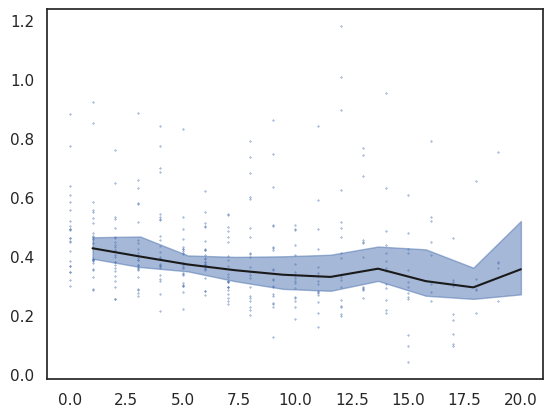

In [46]:
# sns.scatterplot(pdata_core_agg, x='dist_code', y='rec_gene', hue='core_id')
# sns.scatterplot(pdata_core_agg, x='dist_code', y='LR_prod', hue='core_id')


eval_x = np.linspace(1, 20, 10)

smoothed, bottom, top = lowess_with_confidence_bounds(
    pdata_core_agg['dist_code'], pdata_core_agg['LR_prod'], eval_x, lowess_kw={"frac": 0.1}
)

# Plot the confidence interval and fit
fig, ax = plt.subplots()
ax.scatter(pdata_core_agg['dist_code'], pdata_core_agg['LR_prod'], s=0.1)
ax.plot(eval_x, smoothed, c="k")
ax.fill_between(eval_x, bottom, top, alpha=0.5, color="b")

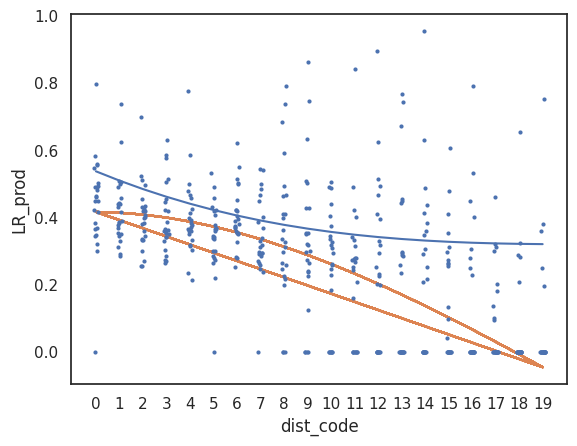

In [122]:
x = pdata_core_agg['dist_code'].to_numpy()
y = pdata_core_agg['LR_prod'].to_numpy()

# plt.scatter(x, y, s=0.5)
fig, ax = plt.subplots()
sns.stripplot(pdata_core_agg, x='dist_code', y='LR_prod', size=3, ax=ax)

ax.plot(np.unique(x), np.poly1d(np.polyfit(pdata_agg['dist'], pdata_agg['LR_prod'], 3))(np.unique(x)))

# pdata_agg_ = pdata_agg.sort_values('dist')
# pdata_agg_['dist_code'] = pdata_agg_.dist_bin.cat.codes
# pdata_agg_ = pdata_agg_.groupby(['dist_code']).LR_prod.apply(np.mean)
# pdata_agg_ = pd.DataFrame(pdata_agg_).reset_index()

pdata_agg_ = pdata_core_agg.sort_values('dist_code').copy()
pdata_agg_ = pdata_agg_.groupby(['dist_code']).LR_prod.apply(np.median)
pdata_agg_ = pd.DataFrame(pdata_agg_).reset_index()

tck_s = splrep(pdata_agg_['dist_code'].to_numpy(), pdata_agg_['LR_prod'].to_numpy(), s=5)
# tck_s = splrep(x, y, s=1)
ax.plot(x, BSpline(*tck_s)(x), '-')

plt.savefig("outs/scatterFit_TRC-EffT_DLL4-NOTCH1.pdf")

In [113]:
pdata_core_agg

core_id          dist_bin   LR_prod  dist_code
0         1    (3.313, 5.179]  0.493518          0
1         1    (5.179, 7.008]  0.441688          1
2         1    (7.008, 8.836]  0.430831          2
3         1   (8.836, 10.665]  0.423634          3
4         1  (10.665, 12.494]  0.358990          4
..      ...               ...       ...        ...
475       9  (30.783, 32.612]       NaN         15
476       9  (32.612, 34.441]       NaN         16
477       9   (34.441, 36.27]       NaN         17
478       9   (36.27, 38.099]       NaN         18
479       9  (38.099, 39.928]       NaN         19

[480 rows x 4 columns]

In [107]:
pdata_agg_

dist_code   LR_prod
0           0       NaN
1           1  0.403747
2           2  0.400714
3           3  0.361715
4           4  0.374814
5           5       NaN
6           6  0.384755
7           7       NaN
8           8       NaN
9           9       NaN
10         10       NaN
11         11       NaN
12         12       NaN
13         13       NaN
14         14       NaN
15         15       NaN
16         16       NaN
17         17       NaN
18         18       NaN
19         19       NaN

In [90]:
pdata_agg.describe()

Core         Size  transcript_counts  control_probe_counts  \
count  4969.000000  4969.000000        4969.000000           4969.000000   
mean     19.279131    65.714270          94.604951              0.001409   
std      13.043281    38.876052          48.447000              0.037510   
min       1.000000     9.140000          11.000000              0.000000   
25%       5.000000    42.350000          59.000000              0.000000   
50%      18.000000    57.430000          85.000000              0.000000   
75%      34.000000    79.090000         119.000000              0.000000   
max      38.000000   646.950000         481.000000              1.000000   

       control_codeword_counts  unassigned_codeword_counts  \
count              4969.000000                 4969.000000   
mean                  0.001811                    0.000604   
std                   0.042524                    0.024566   
min                   0.000000                    0.000000   
25%                   0.000000                    0.000000   
50%                   0.000000                    0.000000   
75%                   0.000000                    0.000000   
max                   1.000000                    1.000000   

       deprecated_codeword_counts  total_counts    cell_area  nucleus_area  \
count                      4969.0   4969.000000  4969.000000   4969.000000   
mean                          0.0     94.604950    68.514038     34.135836   
std                           0.0     48.446999    39.500769     16.383542   
min                           0.0     11.000000    10.024688      4.380156   
25%                           0.0     59.000000    44.840158     23.300626   
50%                           0.0     85.000000    60.283596     30.661095   
75%                           0.0    119.000000    82.500472     42.898439   
max                           0.0    481.000000   659.281274    166.220162   

       ...  pct_counts_in_top_20_genes  pct_counts_in_top_50_genes  \
count  ...                 4969.000000                 4969.000000   
mean   ...                   70.726827                   96.052811   
std    ...                    9.946519                    6.041706   
min    ...                   43.636364                   71.875000   
25%    ...                   64.084507                   92.682927   
50%    ...                   69.629630                  100.000000   
75%    ...                   75.757576                  100.000000   
max    ...                  100.000000                  100.000000   

       pct_counts_in_top_150_genes     n_counts   X_centroid    Y_centroid  \
count                       4969.0  4969.000000  4969.000000   4969.000000   
mean                         100.0    94.604950  4766.118822  10772.801737   
std                            0.0    48.446999  2531.641856   7521.717889   
min                          100.0    11.000000   320.038239    164.196457   
25%                          100.0    59.000000  2437.328369   4091.705566   
50%                          100.0    85.000000  4704.412598   8732.059570   
75%                          100.0   119.000000  6807.083008  18803.396484   
max                          100.0   481.000000  9993.587891  21857.195312   

              dist  sender_gene     rec_gene      LR_prod  
count  4969.000000  4969.000000  4969.000000  4969.000000  
mean     11.445554     0.631098     0.612470     0.389353  
std       6.757563     0.278938     0.255928     0.248838  
min       3.349746     0.098771     0.121587     0.029761  
25%       6.771682     0.423228     0.428234     0.211978  
50%       8.989820     0.578858     0.575364     0.329953  
75%      13.804765     0.786238     0.760588     0.499283  
max      39.927612     1.950296     2.442347     1.970246  

[8 rows x 24 columns]

In [46]:
# xen_dat.write_h5ad("xenium_annotated.h5ad")
xen_dat_filter.write_h5ad("xenium_filter_annotated.h5ad")
